In [2]:
from __future__ import print_function, division
# import mdtraj as md
# from mdtraj.utils import ensure_type
# from mdtraj.geometry import compute_distances, compute_angles
# from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
# from mdtraj.geometry import _geometry
# from mdtraj.utils import ensure_type
# from mdtraj.geometry import compute_distances, compute_angles
from itertools import groupby
#from matplotlib import
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
print(torch.__version__)
import torchmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


2.2.2


In [3]:
dmat = np.load("distance_matrix_full_LIG.npy")
print(dmat.shape)

(1100889, 20)


In [4]:
def combined_residence_events(data):
  idx = np.arange(len(data[:,0]))
  
  bool = np.where(data<.6,1,0)
  any_event_residue = np.any(bool, axis=1)
  
  comp = np.stack([idx,any_event_residue],axis = 1)
  return [i[:,0][1:] if len(i)>1 else i[:,0] for i in filter(lambda x:any(x[:,1]!=0),np.split(comp,np.where(comp[:,1]==0)[0]))]

In [1]:

events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(dmat[0,:])])
mapping_5_476 = np.zeros(len(events_all))
avg_5_476 = np.zeros([len(events_all), len(dmat[0,:])])
mapping_25_476 = np.zeros(len(events_all))
avg_25_476 = np.zeros([len(events_all), len(dmat[0,:])])

# avg_all is all events
# avg_5_476 is middle range
# avg_25_476 is narrowest range

count = 0
for event in events_all:
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(dmat[event[0]:event[-1]+1], axis=0)
  count += 

sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]
print("Longest five events:", sortevents[:5])

mapping_5_476 = mapping_all[mapping_all > 4]
avg_5_476 = avg_all[mapping_all > 4]
avg_5_476 = avg_5_476[mapping_5_476 < 477]
mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

mapping_25_476 = mapping_all[mapping_all > 24]
avg_25_476 = avg_all[mapping_all > 24]
avg_25_476 = avg_25_476[mapping_25_476 < 477]
mapping_25_476 = mapping_25_476[mapping_25_476 < 477]

print("Total events:", len(mapping_all))
print("With avg distance input data of shape:", avg_all.shape)
print("Events between 5 and 476 frames:", len(mapping_5_476))
print("With avg distance in put data of shape:", avg_5_476.shape)
print("Events between 25 and 476 frames:", len(mapping_25_476))
print("With avg distance input data of shape:", avg_25_476.shape)

    

NameError: name 'combined_residence_events' is not defined

[12021.  7432.  5990.  4327.  3629.  3253.  2877.  2839.  2397.  2233.
  2032.  2003.  1990.  1840.  1805.  1700.  1621.  1620.  1603.  1580.]


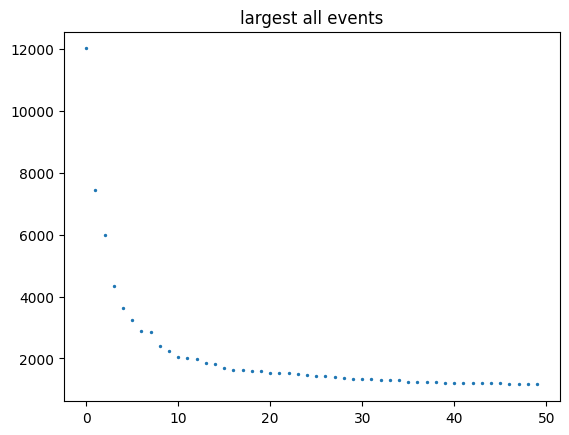

[476. 475. 474. 474. 474. 474. 474. 473. 472. 471. 468. 467. 467. 467.
 466. 466. 464. 463. 462. 462.]


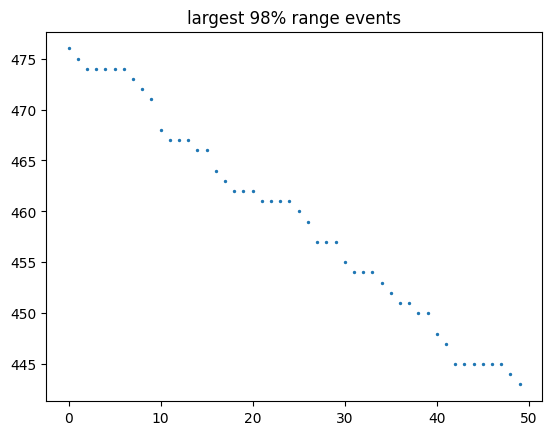

<Figure size 640x480 with 0 Axes>

In [6]:
sortevents = np.sort(mapping_all)[::-1]

plt.scatter(np.arange(50), sortevents[:50], s = 2)
print(sortevents[:20])
plt.title("largest all events")
plt.show()
plt.clf()

sortevents = np.sort(mapping_5_476)[::-1]

plt.scatter(np.arange(50), sortevents[:50], s = 2)
print(sortevents[:20])
plt.title("largest 98% range events")
plt.show()
plt.clf()

# plt.plot(ploteventsintime)
# plt.title("all events over time")
# plt.show()

In [23]:
mapping = mapping_5_476
avg = avg_5_476

In [24]:
print("max length:", np.max(mapping))
print("min length:", np.min(mapping))
# logmapping =  np.log(mapping)
logmapping = mapping/100
print("max log length:",np.max(logmapping))
print("min log length:",np.min(logmapping))

amean = np.mean(avg, 0)
print("mean:", amean)
astd = np.std(avg, 0)
print("std deviation:", astd)

std_avg = (avg - amean)/astd

print("standardized avg distance data")

max length: 476.0
min length: 5.0
max log length: 4.76
min log length: 0.05
mean: [1.42916224 1.37011894 1.31571755 1.35058167 1.227108   1.24078511
 1.2223932  1.24681741 1.24418795 1.21032906 1.20343746 1.25658049
 1.1358778  1.14637195 1.17298661 1.11424589 1.15071183 1.22499229
 1.20205116 1.30301088]
std deviation: [0.48050119 0.49377814 0.52716466 0.51856525 0.50365845 0.50344977
 0.47637328 0.46924951 0.46724376 0.49043033 0.49153119 0.46918486
 0.45909269 0.45092947 0.47246284 0.47498547 0.50627984 0.51832394
 0.54566229 0.55149194]
standardized avg distance data


In [25]:
inputs = torch.from_numpy(std_avg)
inputs = torch.tensor(inputs, dtype=torch.float32)
print(inputs.shape)
print(inputs)
targets= torch.from_numpy(np.reshape(logmapping, (logmapping.shape[0],1)))
targets = torch.tensor(targets, dtype=torch.float32)
print(targets.shape)
print(targets)
dataset = TensorDataset(inputs, targets)


N = len(dataset)
indices = np.arange(N)
indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.85*N)]
test_indices = indices[int(0.85*N):int(1*N)]

print(len(train_indices))
print(train_indices)
train_len = len(train_indices)
print(len(val_indices))
print(val_indices)
val_len = len(val_indices)
print(len(test_indices))
print(test_indices)
test_len = len(test_indices)

a1 = std_avg[train_indices]
m1 = logmapping[train_indices]
a2 = std_avg[val_indices]
m2 = logmapping[val_indices]
a3 = std_avg[test_indices]
m3 = logmapping[test_indices]

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

batch_size = 64
train_dataloader = DataLoader(train_set, batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size)
test_dataloader = DataLoader(test_set, batch_size)

torch.Size([11279, 20])
tensor([[-0.8127, -0.8133, -1.0397,  ...,  0.9876,  0.7791,  0.6235],
        [ 1.7269,  1.7150,  1.4187,  ..., -1.1160, -1.6034, -1.0972],
        [ 0.9718,  0.5622,  0.6083,  ...,  0.9086,  0.7723,  0.5488],
        ...,
        [ 0.4582,  0.2774, -0.3035,  ..., -0.4037, -1.0222, -1.3193],
        [-0.1471, -0.2693, -0.5520,  ..., -1.0696, -1.4198, -1.4658],
        [ 0.3077,  0.3332,  0.2427,  ..., -1.4955, -1.1454, -1.0734]])
torch.Size([11279, 1])
tensor([[0.9600],
        [0.0700],
        [0.1900],
        ...,
        [0.0700],
        [0.1700],
        [1.5800]])
7895
[7083 7872 9845 ... 5281 2278 3721]
1692
[11128  9400 10385 ...  6712  3420  1822]
1692
[ 4383  9222  9290 ...  7346  7362 10154]


/var/folders/d8/ljs_0tq104s4vglq15j0zhnr0000gn/T/ipykernel_21269/3281027760.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/var/folders/d8/ljs_0tq104s4vglq15j0zhnr0000gn/T/ipykernel_21269/3281027760.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = nn.Sequential(
    nn.Linear(20, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(128, 1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                           weight_decay=0.001)


In [186]:
# class SelfAttention(nn.Module):
#     def __init__(self, input_dim):
#         super(SelfAttention, self).__init__()
#         self.input_dim = input_dim
#         self.query = nn.Linear(input_dim, input_dim)
#         self.key = nn.Linear(input_dim, input_dim)
#         self.value = nn.Linear(input_dim, input_dim)
#         self.softmax = nn.Softmax(dim=1)
#         self.final = nn.Linear(input_dim, 1)
        
#     def forward(self, x):
#         queries = self.query(x)
#         keys = self.key(x)
#         values = self.value(x)
#         scores = torch.mm(queries, keys.transpose(0, 1)) / (self.input_dim ** 0.5)
#         attention = self.softmax(scores)
#         weighted = torch.mm(attention, values)
#         out = self.final(weighted)
#         print(out)
#         return out
      
# model_attn = SelfAttention(20)

In [27]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=50
)
preds = clf.predict(a3)

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.9504  | val_0_mse: 0.72772 |  0:00:00s
epoch 1  | loss: 0.55201 | val_0_mse: 0.50128 |  0:00:00s
epoch 2  | loss: 0.44459 | val_0_mse: 0.47551 |  0:00:00s
epoch 3  | loss: 0.41626 | val_0_mse: 0.49476 |  0:00:01s
epoch 4  | loss: 0.41547 | val_0_mse: 0.43447 |  0:00:01s
epoch 5  | loss: 0.3997  | val_0_mse: 0.43676 |  0:00:01s
epoch 6  | loss: 0.37877 | val_0_mse: 0.3865  |  0:00:02s
epoch 7  | loss: 0.37314 | val_0_mse: 0.37973 |  0:00:02s
epoch 8  | loss: 0.35979 | val_0_mse: 0.36748 |  0:00:02s
epoch 9  | loss: 0.36547 | val_0_mse: 0.36061 |  0:00:03s
epoch 10 | loss: 0.34871 | val_0_mse: 0.34874 |  0:00:03s
epoch 11 | loss: 0.34351 | val_0_mse: 0.34953 |  0:00:03s
epoch 12 | loss: 0.34354 | val_0_mse: 0.36041 |  0:00:04s
epoch 13 | loss: 0.33238 | val_0_mse: 0.35699 |  0:00:04s
epoch 14 | loss: 0.33584 | val_0_mse: 0.3371  |  0:00:04s
epoch 15 | loss: 0.33229 | val_0_mse: 0.35375 |  0:00:04s
epoch 16 | loss: 0.32572 | val_0_mse: 0.3418  |  0:00:05s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [28]:
print(preds[:,0])
print(m3)

[0.16716433 1.9245474  0.13103239 ... 0.22286515 0.16074383 1.1457108 ]
[0.32 3.98 0.07 ... 0.06 0.05 0.94]


In [187]:
def train_model(model, optimizer, num_epochs=25):

    # Create a temporary directory to save training checkpoints
    best_model_params_path = os.path.join("tmp_ckpts", 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_loss = 999999

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
                dataset_size = train_len
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_dataloader
                dataset_size = val_len

            running_loss = 0.0

            all_labels = []
            all_preds = []

            # Iterate over data.
            
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # print(inputs)
                    logits = model(inputs)
                    loss = F.mse_loss(logits, labels, reduction='mean')
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                all_preds.append(logits)
                all_labels.append(labels.squeeze(1))


            epoch_loss = running_loss / dataset_size
            all_preds = torch.cat(all_preds)
            all_labels = torch.cat(all_labels)
            # epoch_acc = accuracy_score(all_labels, all_preds)

            print(f'{phase} Loss: {epoch_loss:.4f}')
            
            # print(phase, "Confusion matrix:")
            # print(confusion_matrix(all_labels, all_preds))
            
            print()

            # deep copy the model
            if phase == 'val' and epoch_loss > best_loss:
                best_loss = epoch_loss
                torch.save(model.state_dict(), best_model_params_path)

        print()
        
    # print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    # model.load_state_dict(torch.load(best_model_params_path))
    return model, all_preds, all_labels

In [ ]:
trained_model, ap, al = train_model(model_attn, optimizer, num_epochs=20)

In [189]:
print(torch.mean(ap))
print(torch.mean(al))

ap = torch.exp(ap)
al = torch.exp(al)

print(torch.mean(ap))
print(torch.mean(al))

al = torch.Tensor.numpy(al, force=True)
ap = torch.Tensor.numpy(ap, force=True)

top = (-ap).argsort(axis=0)[:20]
for index in top:
  print("predicted", ap[index], "real:", al[index])


tensor(-0.1532)
tensor(1.4385)
tensor(0.8585)
tensor(28.5802)
predicted [[0.94886893]] real: [12.999999]
predicted [[0.94297945]] real: [1.]
predicted [[0.9421896]] real: [1.]
predicted [[0.9418719]] real: [157.]
predicted [[0.94153184]] real: [502.0001]
predicted [[0.94096494]] real: [1.]
predicted [[0.9400965]] real: [1.]
predicted [[0.9397665]] real: [1.]
predicted [[0.9395847]] real: [1.]
predicted [[0.9389277]] real: [2.]
predicted [[0.9387786]] real: [4.]
predicted [[0.9365426]] real: [3.]
predicted [[0.93595827]] real: [1.]
predicted [[0.9353717]] real: [2.]
predicted [[0.9351368]] real: [2.]
predicted [[0.9347571]] real: [1.]
predicted [[0.93463564]] real: [3.]
predicted [[0.9345478]] real: [1.]
predicted [[0.93442136]] real: [14.000001]
predicted [[0.93425846]] real: [339.00003]


In [190]:
def test_model(model):
    model.eval()
    dataloader = test_dataloader
    dataset_size = test_len
    running_loss = 0.0
            
    all_labels= []
    all_preds= []
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        logits = model(inputs)
        loss = F.mse_loss(logits, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        all_preds.append(logits)
        all_labels.append(labels)


    epoch_loss = running_loss / dataset_size
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    print(f'Test Loss: {epoch_loss:.4f}')
    
    return all_preds, all_labels



In [191]:
ap2, al2 = test_model(trained_model)

tensor([[-0.0966],
        [-0.1325],
        [-0.1483],
        [-0.1440],
        [-0.1465],
        [-0.1338],
        [-0.1200],
        [-0.1229],
        [-0.1349],
        [-0.1327],
        [-0.1152],
        [-0.1333],
        [-0.1227],
        [-0.1199],
        [-0.1284],
        [-0.1186],
        [-0.1333],
        [-0.1083],
        [-0.1260],
        [-0.1309],
        [-0.1498],
        [-0.1360],
        [-0.1272],
        [-0.1090],
        [-0.1455],
        [-0.1137],
        [-0.1193],
        [-0.1157],
        [-0.1230],
        [-0.1328],
        [-0.1365],
        [-0.1553],
        [-0.1172],
        [-0.1090],
        [-0.1270],
        [-0.1420],
        [-0.1385],
        [-0.1369],
        [-0.1325],
        [-0.1292],
        [-0.1364],
        [-0.1404],
        [-0.1262],
        [-0.1208],
        [-0.1359],
        [-0.1449],
        [-0.1418],
        [-0.1370],
        [-0.1294],
        [-0.1423],
        [-0.1208],
        [-0.1308],
        [-0.

In [29]:
print(preds[:,0])
print(m3)

ap2 = preds[:,0]*100
al2 = m3*100

print(np.mean(ap2))
print(np.mean(al2))

[0.16716433 1.9245474  0.13103239 ... 0.22286515 0.16074383 1.1457108 ]
[0.32 3.98 0.07 ... 0.06 0.05 0.94]
50.014797
54.118203309692674


In [14]:
print(preds[:,0])
print(m3)

ap2 = preds[:,0]
al2 = m3

print(np.mean(ap2))
print(np.mean(al2))

ap2 = np.exp(ap2)
al2 = np.exp(al2)

print(np.mean(ap2))
print(np.mean(al2))

[2.4383054 4.857026  4.422056  ... 2.4446843 3.310237  2.578857 ]
[1.60943791 4.52178858 4.87519732 ... 2.56494936 2.77258872 2.63905733]
3.1616707
3.1403221277075124
41.64686
53.826241134751776


In [238]:
print(torch.mean(ap2))
print(torch.mean(al2))

# ap2= (ap2*std) + mean
# al2= (al2*std) + mean

ap2 = torch.exp(ap2)
al2 = torch.exp(al2)

print(torch.mean(ap2))
print(torch.mean(al2))

al2 = torch.Tensor.numpy(al2, force=True)
ap2 = torch.Tensor.numpy(ap2, force=True)

TypeError: mean(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [30]:
top = (-al2).argsort(axis=0)[:10]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])
  
print("")
  
top = (-ap2).argsort(axis=0)[:10]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])
  
print("")
  
bottom = (ap2).argsort(axis=0)[:10]
for index in bottom:
  print("predicted", ap2[index], "real:", al2[index])
  

predicted 174.58582 real: 474.0
predicted 169.97806 real: 468.0
predicted 206.46109 real: 467.0
predicted 208.61203 real: 463.0
predicted 248.236 real: 461.00000000000006
predicted 218.3781 real: 459.0
predicted 169.84439 real: 457.0
predicted 207.04446 real: 457.0
predicted 190.24379 real: 440.00000000000006
predicted 243.4678 real: 434.99999999999994

predicted 349.74265 real: 305.0
predicted 341.6825 real: 390.0
predicted 315.48087 real: 419.00000000000006
predicted 301.60538 real: 148.0
predicted 299.7774 real: 214.0
predicted 298.6082 real: 171.0
predicted 291.18152 real: 169.0
predicted 278.26175 real: 222.00000000000003
predicted 277.6863 real: 61.0
predicted 258.00204 real: 241.0

predicted -2.6095617 real: 18.0
predicted -1.9113699 real: 7.000000000000001
predicted -1.188053 real: 5.0
predicted 0.80144906 real: 18.0
predicted 1.1837068 real: 6.0
predicted 1.3562165 real: 8.0
predicted 1.5329645 real: 23.0
predicted 1.5509002 real: 5.0
predicted 1.6932971 real: 15.0
predicted 1

r2: 0.749070561382501


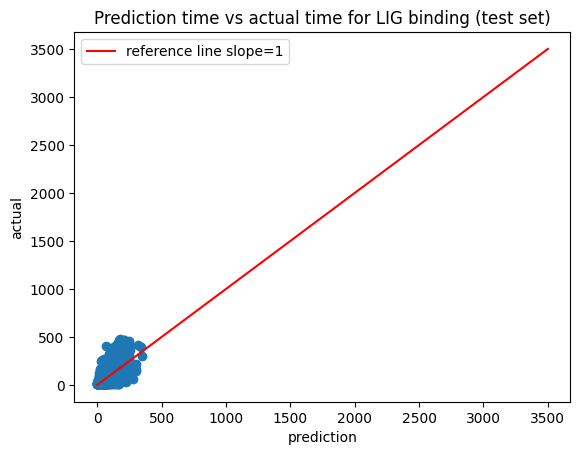

In [31]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 3500,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Prediction time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

r2: 0.749070561382501


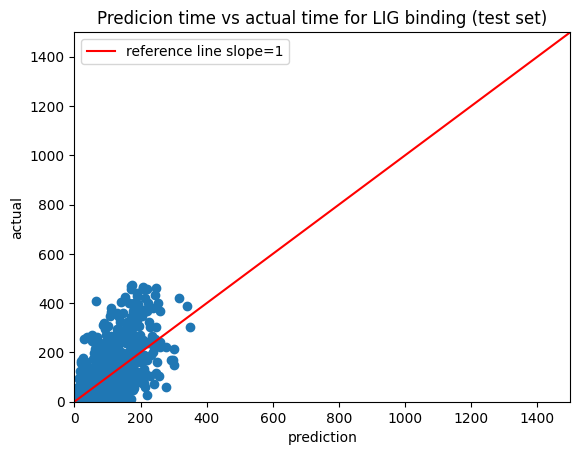

In [32]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 3500,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.ylim([0,1500])
plt.xlim([0,1500])
plt.show()

r2: 0.749070561382501


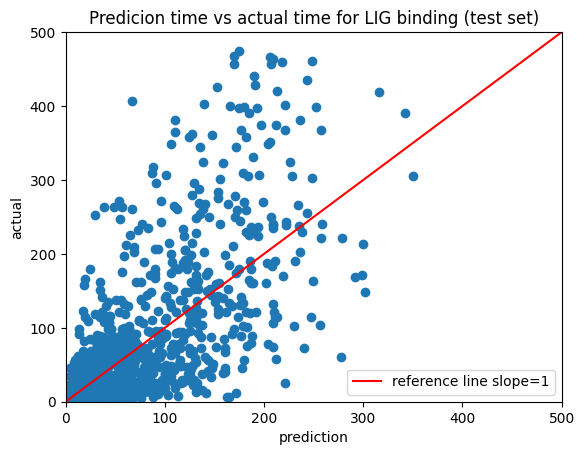

In [33]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 3500,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.ylim([0,500])
plt.xlim([0,500])
plt.show()

r2: 0.749070561382501


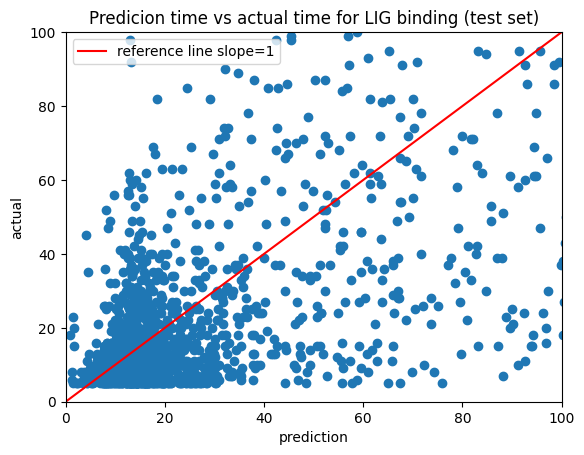

In [34]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 3500,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.ylim([0,100])
plt.xlim([0,100])
plt.show()

r2: 0.749070561382501


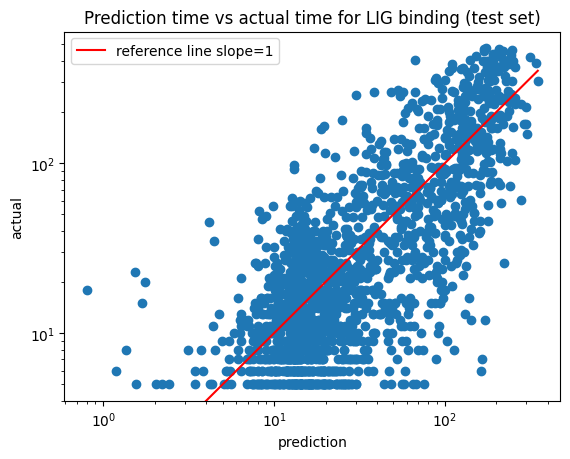

In [35]:
plt.scatter(ap2,al2)
plt.xscale("log")
plt.yscale("log")
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
# x = np.linspace(min(ap2[:,0]), max(ap2[:,0]),20)
x = np.linspace(min(ap2), max(ap2),20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Prediction time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()